<a href="https://colab.research.google.com/github/AryanGupta20605/DataMining/blob/main/Density_based_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

In [ ]:
data = pd.read_csv("/content/CC GENERAL.csv")
df=data.copy()
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check
check(df)

,column,dtypes,nunique,sum_null
0,CUST_ID,object,8950,0
1,BALANCE,float64,8871,0
2,BALANCE_FREQUENCY,float64,43,0
3,PURCHASES,float64,6203,0
4,ONEOFF_PURCHASES,float64,4014,0
5,INSTALLMENTS_PURCHASES,float64,4452,0
6,CASH_ADVANCE,float64,4323,0
7,PURCHASES_FREQUENCY,float64,47,0
8,ONEOFF_PURCHASES_FREQUENCY,float64,47,0
9,PURCHASES_INSTALLMENTS_FREQUENCY,float64,47,0


In [ ]:
df = df.dropna()

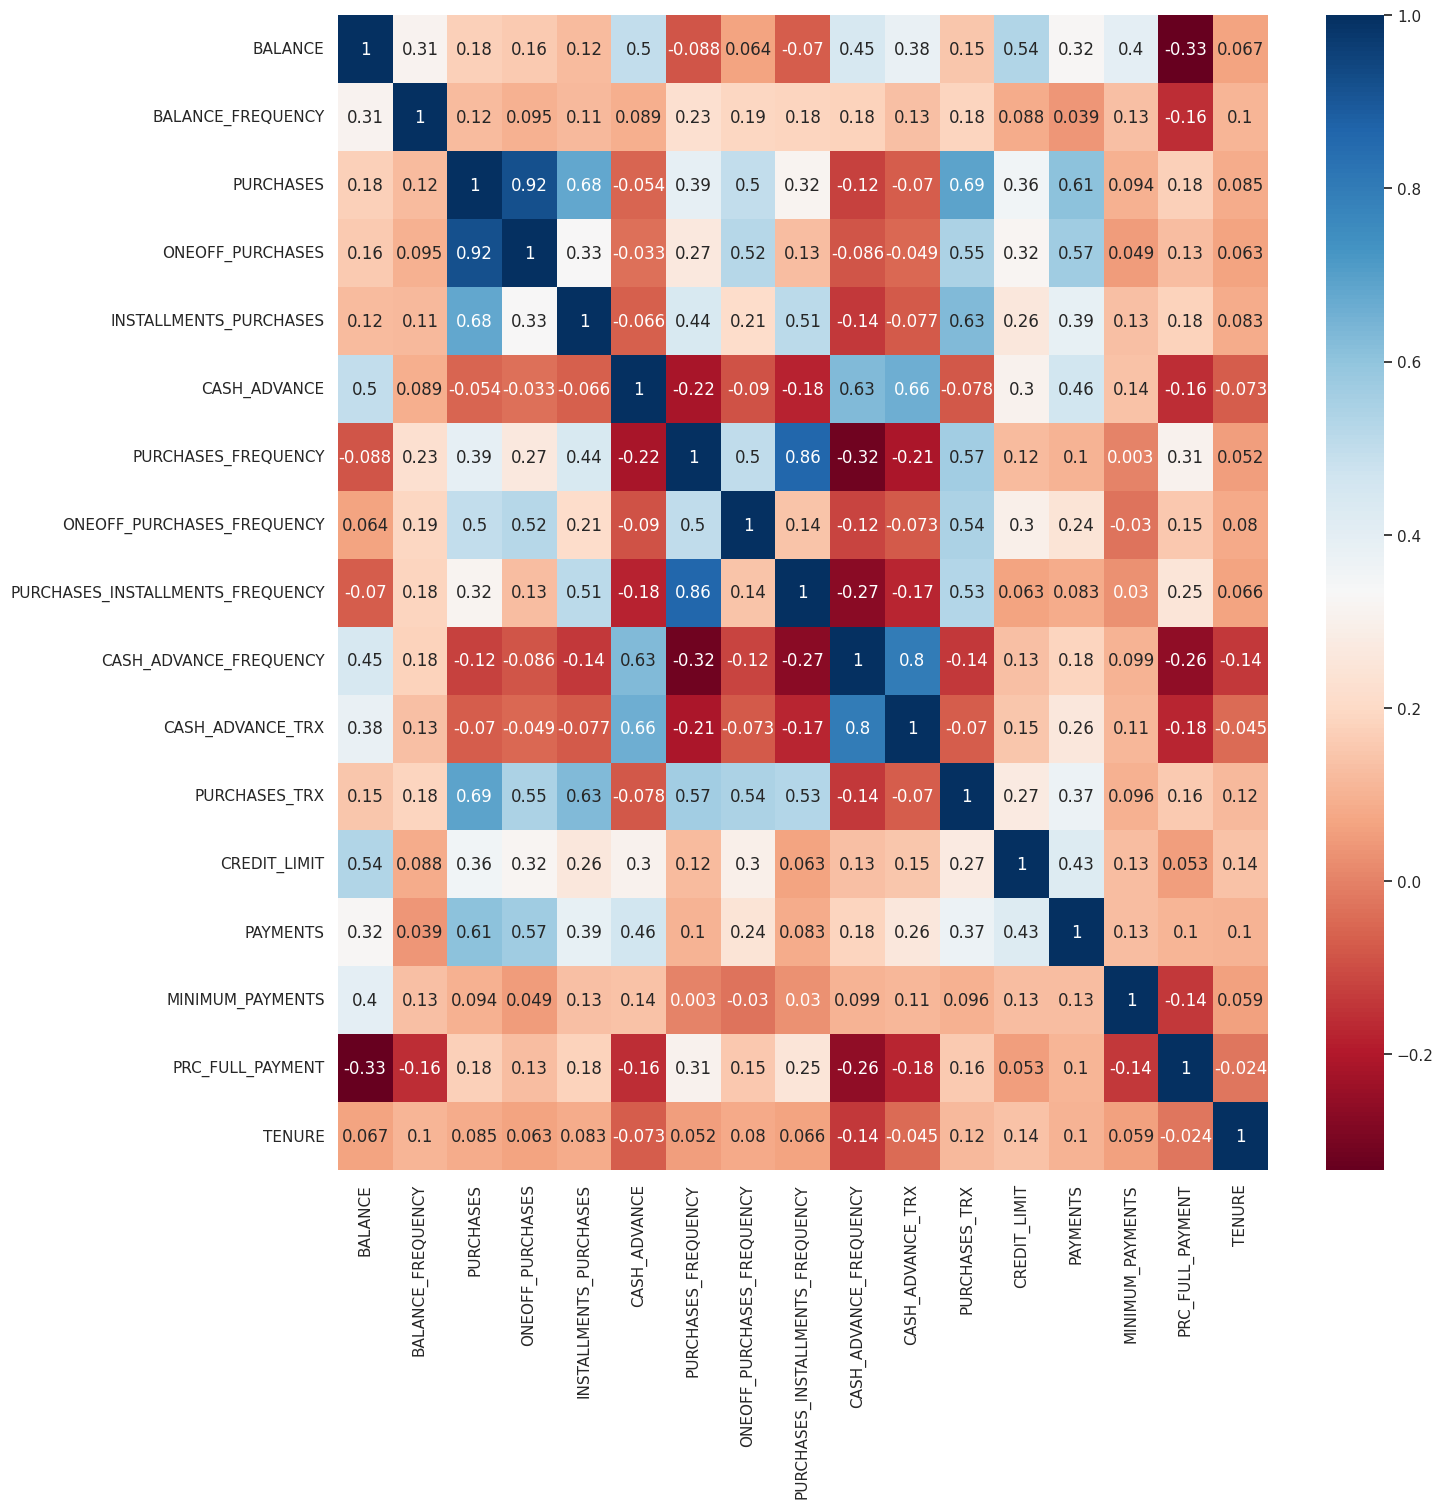

['ONEOFF_PURCHASES', 'PURCHASES_INSTALLMENTS_FREQUENCY']

In [ ]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.80):
    # Select only the numeric columns from the DataFrame
    numeric_dataframe = dataframe.select_dtypes(include=['number'])

    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu",annot=True)
        plt.show()

    return drop_list

# Usage example:
high_correlated_cols(df, plot=True)

In [ ]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 8636
Variables: 18
cat_cols: 1
num_cols: 16
cat_but_car: 1
num_but_cat: 1


In [ ]:
def outlier_thresholds(dataframe, variable, low_quantile=0.15, up_quantile=0.85):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
      print(col, check_outlier(df, col))

BALANCE True
BALANCE_FREQUENCY True
PURCHASES True
ONEOFF_PURCHASES True
INSTALLMENTS_PURCHASES True
CASH_ADVANCE True
PURCHASES_FREQUENCY False
ONEOFF_PURCHASES_FREQUENCY False
PURCHASES_INSTALLMENTS_FREQUENCY False
CASH_ADVANCE_FREQUENCY True
CASH_ADVANCE_TRX True
PURCHASES_TRX True
CREDIT_LIMIT True
PAYMENTS True
MINIMUM_PAYMENTS True
PRC_FULL_PAYMENT False


In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

In [ ]:
df= df.drop(columns=['ONEOFF_PURCHASES', 'PURCHASES_INSTALLMENTS_FREQUENCY',"CUST_ID"],axis=1)

In [ ]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

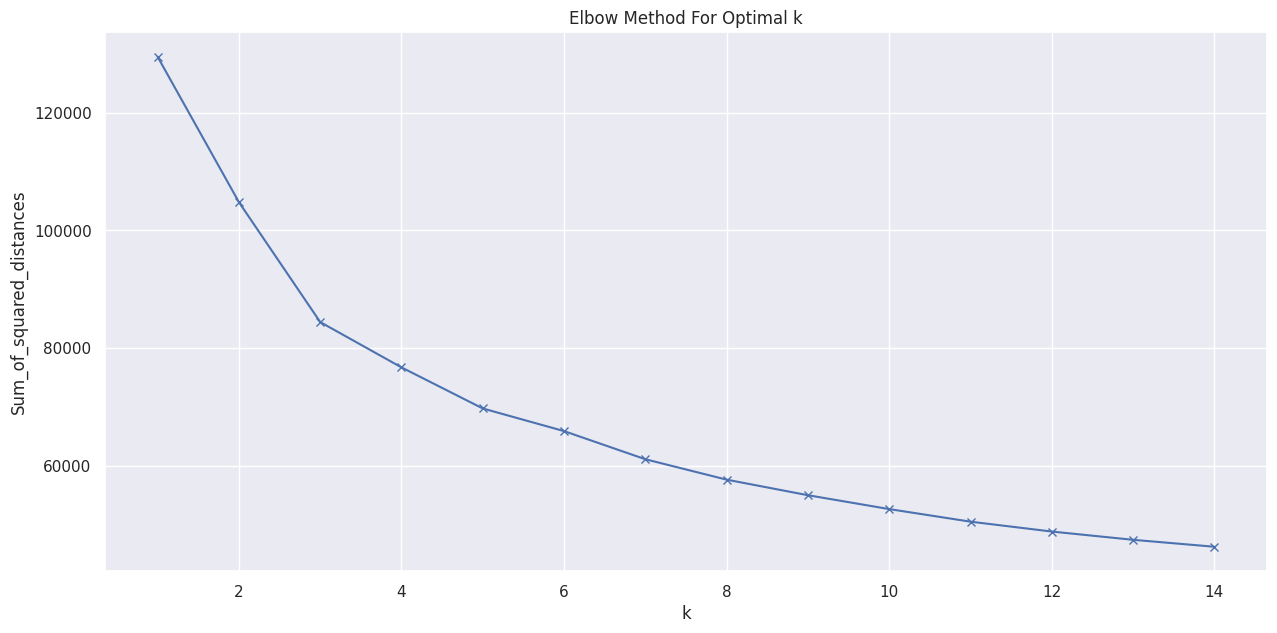

In [ ]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_df)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(15,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

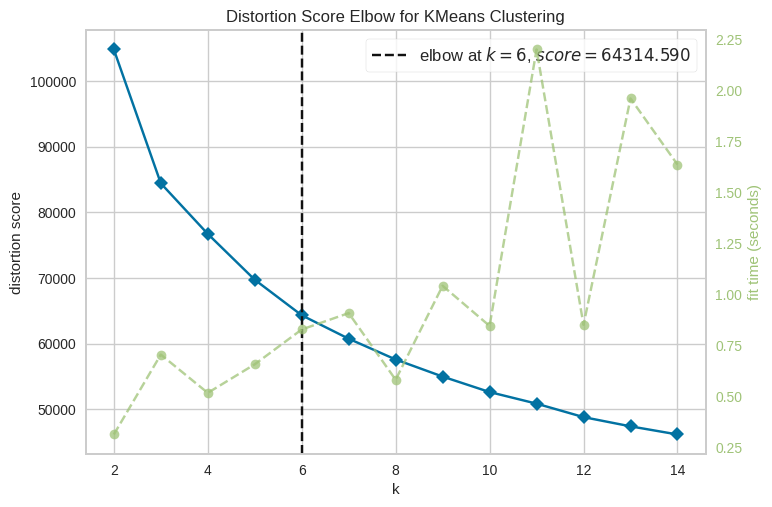

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 15))
elbow.fit(scaled_df)
elbow.show()

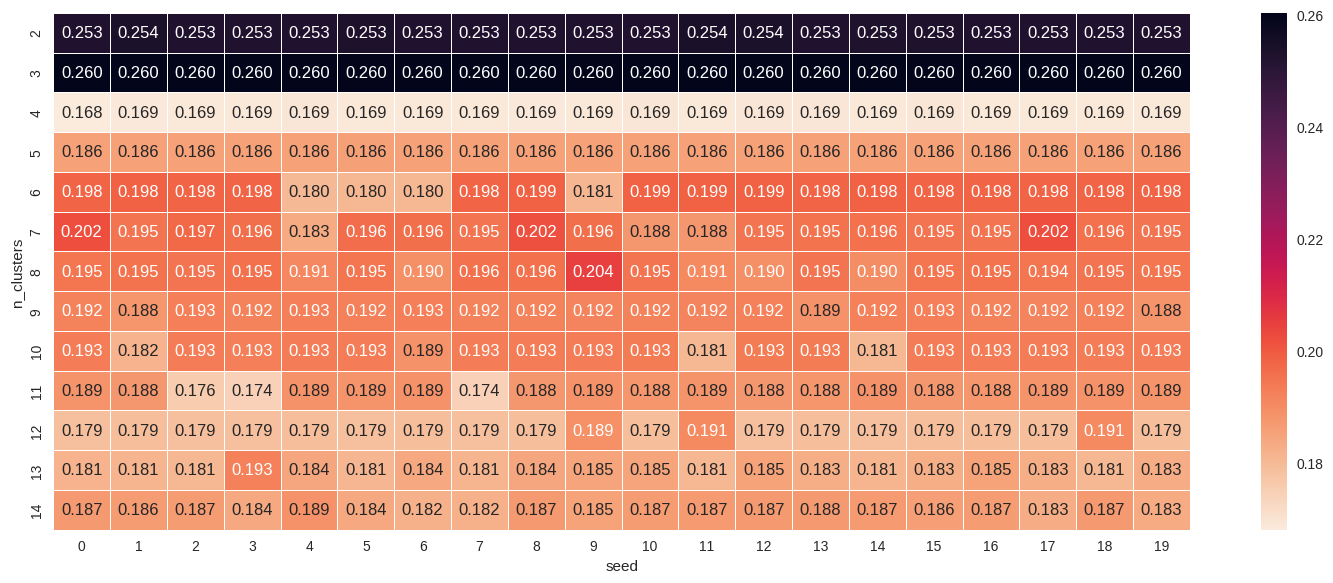

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(scaled_df)
        silhouette_avg = silhouette_score(scaled_df, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

In [ ]:
kmeans = KMeans(n_clusters=4).fit(scaled_df)
kmeans.n_clusters
kmeans.cluster_centers_
kmeans.labels_
scaled_df[0:5]

array([[-0.7956634 , -0.41278532, -0.64363217, -0.48099728, -0.58681616,
        -0.82076881, -0.68627958, -0.69206315, -0.62127666, -0.65638063,
        -0.97382857, -0.78565256, -0.66904782, -0.53772694,  0.35518066],
       [ 0.86338517,  0.05246419, -0.72262611, -0.65537612,  3.19388709,
        -1.2361389 , -0.68627958,  0.57586988,  0.23922657, -0.77052229,
         0.69079622,  1.45741887,  0.53859537,  0.21238001,  0.35518066],
       [ 0.49221608,  0.5177137 , -0.08241914, -0.65537612, -0.58681616,
         1.25607662,  2.6466512 , -0.69206315, -0.62127666, -0.08567233,
         0.82951495, -0.54401505, -0.03757383, -0.53772694,  0.35518066],
       [-0.38802642,  0.5177137 , -0.70937765, -0.65537612, -0.58681616,
        -1.0284551 , -0.40853646, -0.69206315, -0.62127666, -0.71345146,
        -0.91834108, -0.5116629 , -0.53275035, -0.53772694,  0.35518066],
       [ 0.13259078,  0.5177137 ,  0.38136802,  1.78168702, -0.58681616,
         0.42533895, -0.68627958, -0.69206315, 

In [ ]:
clusters_kmeans = kmeans.labels_

df["cluster"] = clusters_kmeans


df["cluster"] = df["cluster"] + 1

df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,95.40,0.000000,0.166667,0.000000,0.00,0.0,2,1000.0,201.802084,139.509787,0.000000,12,3
1,3202.467416,0.909091,0.00,0.00,5596.118623,0.000000,0.000000,0.25,4.0,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,0.00,0.000000,1.000000,1.000000,0.00,0.0,12,7500.0,622.066742,627.284787,0.000000,12,1
4,817.714335,1.000000,16.00,0.00,0.000000,0.083333,0.083333,0.00,0.0,1,1200.0,678.334763,244.791237,0.000000,12,3
5,1809.828751,1.000000,1333.28,1333.28,0.000000,0.666667,0.000000,0.00,0.0,8,1800.0,1400.057770,2407.246035,0.000000,12,1


In [ ]:
df.groupby("cluster").agg("mean")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,
1,696.151041,0.934175,917.834467,482.774314,125.179738,0.834235,0.252180,0.030209,0.517339,17.078202,3746.397825,1024.382073,429.987626,0.277054,11.562633
2,4085.444108,0.966088,430.038823,158.806579,3424.535191,0.281163,0.122886,0.446173,10.606686,6.508535,7029.661839,2713.313683,1414.393489,0.035688,11.418919
3,972.455652,0.815530,209.417311,52.931275,540.632499,0.162115,0.066905,0.116221,2.053901,2.545861,3045.995632,871.352909,442.898608,0.075417,11.438058
4,2361.993377,0.980431,3475.177700,1272.523920,494.332599,0.942841,0.638741,0.072150,1.595124,48.406310,7886.806883,3735.632209,933.883747,0.276639,11.922562


PCA

In [ ]:
df= df.reset_index()

In [ ]:
y = df["cluster"]
X = df.drop(["cluster"], axis=1)

In [ ]:
from sklearn.decomposition import PCA


def create_pca_df(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2'])
    final_df = pd.concat([pca_df, pd.DataFrame(y)], axis=1)
    return final_df

pca_df = create_pca_df(X, y)

In [ ]:
pca_df

,PC1,PC2,cluster
0,-1.386649,-1.477984,3
1,-1.247834,2.997026,2
2,1.593454,-0.132514,1
3,-1.275604,-0.991843,3
4,1.054469,0.264699,1
...,...,...,...
8631,-2.446505,-2.439501,3
8632,-0.796041,-2.432350,1
8633,-1.395559,-2.411102,1
8634,-2.683081,-1.761127,3


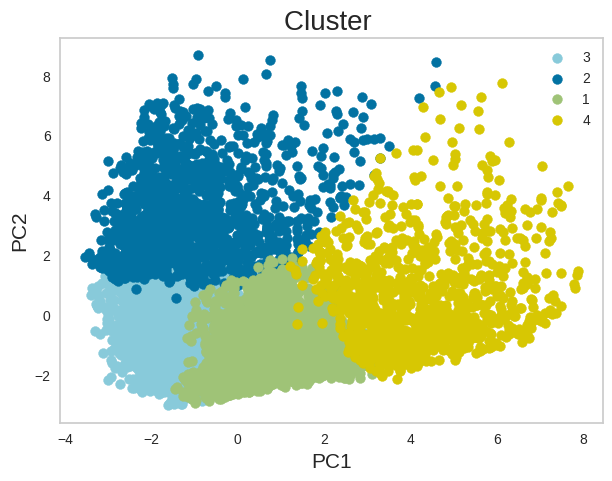

In [ ]:
import random
def plot_pca(dataframe, target):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_title(f'{target.capitalize()} ', fontsize=20)

    targets = list(dataframe[target].unique())
    colors = random.sample(['r', 'b', "g", "y", "c"], len(targets))

    for t, color in zip(targets, colors):
        indices = dataframe[target] == t
        ax.scatter(dataframe.loc[indices, 'PC1'], dataframe.loc[indices, 'PC2'], c=color, s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()

plot_pca(pca_df, "cluster")

In [ ]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
def visualize(df, labels):
    names =   [ "_".join(map(str, el)) for el in  zip(labels, df.index)]

#     reducer = PCA(n_components=3, random_state=RS)
    reducer = TSNE(n_components=3, random_state=42)
#     reducer = umap.UMAP(n_components=3, random_state=RS)

    reduced_data = reducer.fit_transform(df.values)


    black3dbg = dict(
            showbackground = True,
            backgroundcolor ="rgb(10,10,10)",
            gridcolor = "rgb(250, 250, 250)",
            gridwidth=1.5,
            zeroline = False)


    fig = go.Figure(data=[go.Scatter3d(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        z=reduced_data[:, 2],
        mode='markers',


        text=names,

        marker=dict(
            size=12,
            color=labels,
            colorscale='spectral',
            opacity=0.8,
        )
    )])
    fig.update_layout(
#         showlegend=True,
        autosize=False,
        width=1000,
        height=1000)
    fig.update_scenes(xaxis=black3dbg,
                      yaxis=black3dbg,
                      zaxis=black3dbg,
                      camera_eye=dict(x=1.75, y=1.75, z=1))
    fig.show()
visualize(pca_df, clusters_kmeans)